In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [2]:
# Download the data

df_yahoo = yf.download('AAPL', start = '2010-01-01',
                end='2020-01-01',
                progress=False)

In [3]:
df_yahoo = df_yahoo.loc[:,  ['Adj Close']]
df_yahoo.rename(columns = {'Adj Close': 'adj_close'}, inplace = True)

In [4]:
# Simple returns 

df_yahoo['simple_rtn'] = df_yahoo['adj_close'].pct_change()

In [5]:
# Log returns

In [6]:
df_yahoo['log_rtn'] = np.log(df_yahoo.adj_close/ df_yahoo.adj_close.shift(1))

#### Non-Gaussian distribution of returns

In [7]:
# Probability Density Function (PDF)

r_range = np.linspace(min(df_yahoo.log_rtn[1:]), max(df_yahoo.log_rtn[1:]), num = 1000)
mu = df_yahoo.log_rtn.mean()
sigma = df_yahoo.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc = mu, scale = sigma)

/Users/anna/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Q-Q plot')

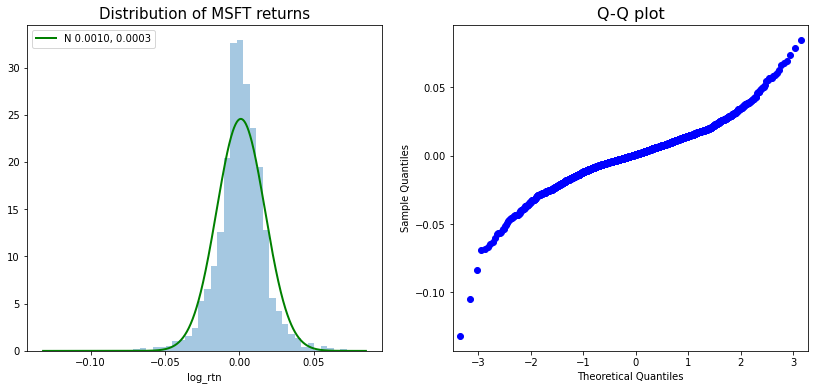

In [8]:
# Plot the histogram and QQ-Plot

fig, ax = plt.subplots(1, 2, figsize = (14, 6))

# histogram
sns.distplot(df_yahoo.log_rtn, kde = False, norm_hist = True, ax = ax[0])
ax[0].set_title('Distribution of MSFT returns', fontsize = 15)
ax[0].plot(r_range, norm_pdf, 'g', lw = 2, label = f'N {mu:.4f}, {sigma**2:.4f}')
ax[0].legend(loc = 'upper left')

# qq-plot
qq = sm.qqplot(df_yahoo.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)

<AxesSubplot:title={'center':'Daily MSFT returns'}, xlabel='Date'>

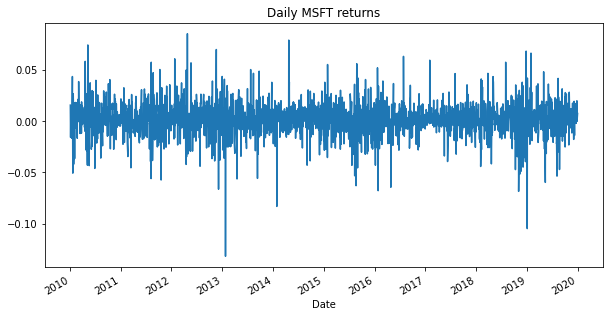

In [9]:
# Volatility clustering 

df_yahoo.log_rtn.plot(title = 'Daily MSFT returns', figsize = (10, 5))

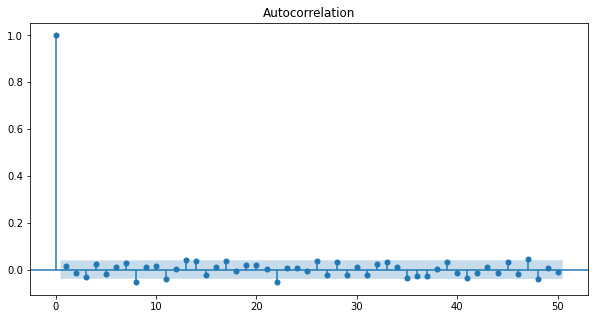

In [10]:
# Absence of autocorrelation in returns

# parameters for the autocorrelation plot
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

# ACF (AUTOCORRELATION FUNCTION)
fig, ax = plt.subplots(figsize=(10, 5))
acf = smt.graphics.plot_acf(df_yahoo.log_rtn[1:], lags= N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax = ax)
plt.show()


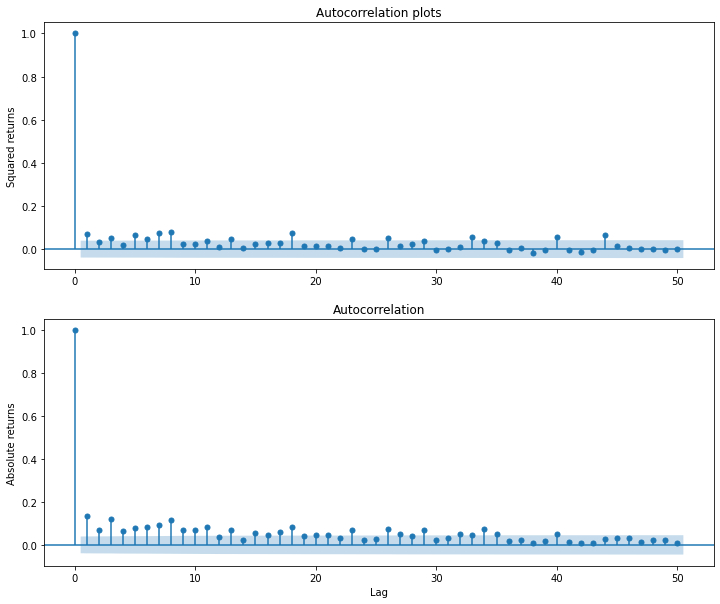

In [16]:
# Small and decreasing autocorrelation in squared/absolute returns

# create the acf plots
fig, ax = plt.subplots(2, 1, figsize = (12, 10))
smt.graphics.plot_acf(df_yahoo.log_rtn[1:] ** 2, lags=N_LAGS, alpha= SIGNIFICANCE_LEVEL, ax = ax[0])
ax[0].set(title = 'Autocorrelation plots', ylabel = 'Squared returns')

smt.graphics.plot_acf(np.abs(df_yahoo.log_rtn[1:]), lags = N_LAGS, alpha = SIGNIFICANCE_LEVEL, ax = ax[1])
ax[1].set(ylabel = 'Absolute returns', xlabel = 'Lag')
plt.show()


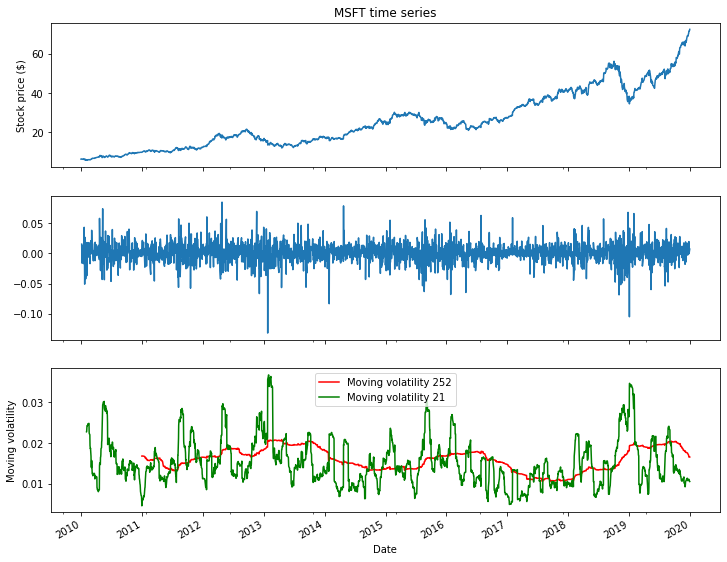

In [56]:
# Leverage effect

# calculate volatility measures as rolling standard deviations

df_yahoo['moving_std_252'] = df_yahoo[['log_rtn']].rolling(window= 252).std()
df_yahoo['moving_std_21'] = df_yahoo[['log_rtn']].rolling(window= 21).std()

# plot the series for comparison

fig, ax = plt.subplots(3, 1, figsize = (12, 10), sharex = True)
df_yahoo.adj_close.plot(ax = ax[0])
ax[0].set(title = 'MSFT time series', ylabel = 'Stock price ($)')
df_yahoo.log_rtn.plot(ax = ax[1])
ax[1].set(label = 'Log returns (%)')
df_yahoo.moving_std_252.plot(ax = ax[2], color = 'r', label = 'Moving volatility 252')
df_yahoo.moving_std_21.plot(ax = ax[2], color = 'g', label = 'Moving volatility 21')

ax[2].set(ylabel = 'Moving volatility', xlabel = 'Date')
ax[2].legend()
plt.show()

In [46]:
# CBOE volatility index

# Download and preprocess the price of the SP500 and VIX

df = yf.download(['^GSPC', '^VIX'], start= '1985-01-01', end = '2020-12-31', progress = 'False')
df = df[['Adj Close']]
df.columns = df.columns.droplevel(0)
df = df.rename(columns = {'^GSPC': 'sp500', '^VIX': 'vix'})
print(df.columns)
# calculate the log returns 

df['log_rtn'] = np.log(df['sp500'] / df['sp500'].shift(1))
df['vol_rtn'] = np.log(df['vix'] / df['vix'].shift(1))
df.dropna(how = 'any', axis = 0, inplace = True)

[*********************100%***********************]  2 of 2 completed
Index(['sp500', 'vix'], dtype='object')


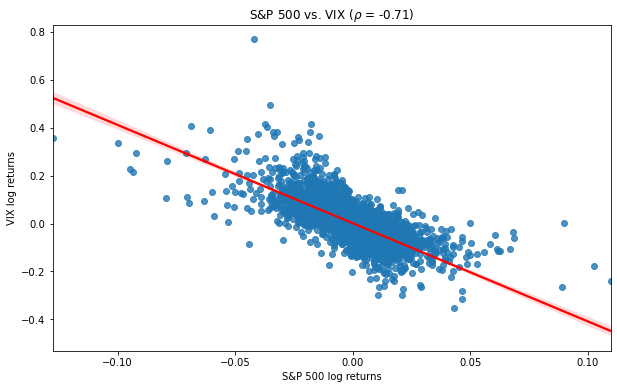

In [55]:
# Plot a scatterplot with the returns on the axes and fit a regression line to identify the trend

# correltation between log returns and volatility returns
fig, ax = plt.subplots(figsize = (10, 6))

corr_coeff = df.log_rtn.corr(df.vol_rtn)
sns.regplot(x = 'log_rtn', y = 'vol_rtn', data = df, line_kws = {'color': 'red'}, ax = ax)
ax.set(title = f'S&P 500 vs. VIX ($\\rho$ = {corr_coeff:.2f})',
 ylabel='VIX log returns',
 xlabel='S&P 500 log returns')

plt.show()

We can see that both the negative slope of the regression line and a strong
negative correlation between the two series confirm the existence of the leverage
effect in the return series.